In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import scipy
import ast
from math import nan
import random

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [2]:
models = [0] + [i for i in range(7, 25)]
results = {}
for i in models:
    results[i] = pd.read_csv("/data/wiay/2386142c/msci_project/condor_jobs/wandb_bayes_sweep_individual_winter/best_models/{}.csv".format(i), 
                            converters={"all_q": ast.literal_eval,
                                        "all_err": ast.literal_eval,
                                        "y": ast.literal_eval,
                                        "median": ast.literal_eval,
                                        "hi": ast.literal_eval,
                                        "lo": ast.literal_eval})

In [3]:
for x in results:
    print(len(results[x]))

213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213
213


In [3]:
def graph_errors(df):
    fig, ax = plt.subplots(2,2, figsize=(15,10))
    
    ax[0,0].set_title("Absolute quantile errors for prediction window")
    ax[0,0].scatter(df["ds"], df["max_q"], c="b", label="Maximum error")
    ax[0,0].plot(df["ds"], df["avg_q"], c="r", label="Average error")

    ax[0,1].set_title("Absolute errors for prediction window")
    ax[0,1].scatter(df["ds"], df["max_err"], c="b", label="Maximum error")
    ax[0,1].plot(df["ds"], df["avg_err"], c="r", label="Average error")

    all_qs = np.array(df["all_q"].tolist()).flatten()
    all_qs = [0 if m>50 else m for m in all_qs]
    _, bins, _ = ax[1,0].hist(all_qs, 300, density=1, alpha=0.5)
    mu, sigma = scipy.stats.norm.fit(all_qs)
    best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
    abs_qs = [abs(i) for i in all_qs]
    abs_avg = sum(abs_qs)/len(abs_qs)

    ax[1,0].plot(bins, best_fit_line, label="Avg: {:.3g}, SD: {:.3g}, abs avg: {:.3g}".format(mu, sigma, abs_avg))
    ax[1,0].set_xlim([-sigma*5,sigma*5])

    all_errs = np.array(df["all_err"].tolist()).flatten()
    all_errs = [50 if m>50 else m for m in all_errs]
    _, bins2, _ = ax[1,1].hist(all_errs, 300, density=1, alpha=0.5)
    mu2, sigma2 = scipy.stats.norm.fit(all_errs)
    best_fit_line2 = scipy.stats.norm.pdf(bins2, mu2, sigma2)
    abs_errs = [abs(i) for i in all_errs]
    abs_avg2 = sum(abs_errs)/len(abs_errs)

    ax[1,1].plot(bins2, best_fit_line2, label="Avg: {:.3g}, SD: {:.3g}, abs avg: {:.3g}".format(mu2, sigma2, abs_avg2))
    ax[1,1].set_xlim([-sigma2*5,sigma2*5])
    
    
    for a in ax.flatten():
        a.legend()
    
    plt.show()

def compute_quants(df):
    
    all_qs = np.array(df["all_q"].tolist()).flatten()
    all_qs = [50 if m>50 else m for m in all_qs]
    mu, sigma = scipy.stats.norm.fit(all_qs)
    abs_qs = [abs(i) for i in all_qs]
    abs_avg = sum(abs_qs)/len(abs_qs)
    good_qs = [i for i in all_qs if i<=1]
    q_frac = len(good_qs)/len(all_qs)
     
    
    all_errs = np.array(df["all_err"].tolist()).flatten()
    all_errs = [50 if m>50 else m for m in all_errs]
    mu2, sigma2 = scipy.stats.norm.fit(all_errs)
    abs_errs = [abs(i) for i in all_errs]
    abs_avg2 = sum(abs_errs)/len(abs_errs)
    
    r = np.asarray(abs_errs)**2
    rmse = sum(r)/len(r)
    
    return(mu, sigma, abs_avg, mu2, sigma2, abs_avg2, q_frac, rmse)

In [4]:
def import_one_series(usage_file, usage_column, weather_file, weather_columns): 
     
  usage_df = pd.read_csv(usage_file)
  usage_df = usage_df[[usage_column]]
  usage_df = usage_df.rename(columns={usage_column: "y"})

  print(usage_df.mean()["y"])
  print(usage_df.std()["y"]) 

  #usage_df["y"] = (usage_df["y"] - usage_df.mean()["y"])/usage_df.std()["y"]
  usage_df["unique_id"] = usage_column
  usage_df["ds"] = [pd.Timestamp(701280+x, unit="h") for x in usage_df.index]
    
  usage_df["day_of_week_sin"] = [np.sin((2*np.pi*x.day_of_week)/6) for x in usage_df["ds"]]
  usage_df["day_of_week_cos"] = [np.cos((2*np.pi*x.day_of_week)/6) for x in usage_df["ds"]]
    
  usage_df["month_sin"] = [np.sin((2*np.pi*x.month)/12) for x in usage_df["ds"]]
  usage_df["month_cos"] = [np.cos((2*np.pi*x.month)/12) for x in usage_df["ds"]]
    
  usage_df["hour_sin"] = [np.sin((2*np.pi*x.hour)/24) for x in usage_df["ds"]]
  usage_df["hour_cos"] = [np.cos((2*np.pi*x.hour)/24) for x in usage_df["ds"]]

  weather_df = pd.read_csv(weather_file)
  weather_df_select = weather_df[[i for i in weather_columns]]
  weather_df_norm = weather_df_select  
  #weather_df_norm = (weather_df_select - weather_df_select.mean())/weather_df_select.std()

  data_df = pd.concat([usage_df, weather_df_norm], axis=1)

  #print("Head:")
  #print(data_df.head())
  #print("Describe:")
  #print(data_df.describe())
  
  return(data_df)

def arrange_multiple_series(usage_file, usage_column, weather_file, weather_columns, training_data_fraction, training_data_series):
  print("Importing data {} and {}".format(usage_file, weather_file))
  all_df = 0
  training_df = 0
  for column in usage_column:
    temp = import_one_series(usage_file, column, weather_file, weather_columns)
    if type(all_df) == int:
      all_df = temp
    else:
      all_df = pd.concat([all_df, temp])
    if column in training_data_series:
      length = len(temp)
      cutoff = int(length*training_data_fraction)
      temp2 = temp[:cutoff]
      if type(training_df) == int:
        training_df = temp2
      else:
        training_df = pd.concat([training_df, temp2])
  print("Data has length {}. Using {} for training.".format(length, cutoff))
  return(all_df, training_df)

def save_data_to_pickle(all_df, training_df):
  all_df_name = "/data/wiay/2386142c/msci_project/condor_jobs/data/processed_data/{}ADF.pck".format(time.strftime("%Y-%m-%d-%H_%M_%S"))
  training_df_name = "/data/wiay/2386142c/msci_project/condor_jobs/data/processed_data/{}TDF.pck".format(time.strftime("%Y-%m-%d-%H_%M_%S"))
  with open(all_df_name, "wb") as f:
    pickle.dump(all_df, f)
  with open(training_df_name, "wb") as f:
    pickle.dump(training_df, f)

In [5]:
all_df, training_df = arrange_multiple_series("2050HighMedium.csv", 
                                              ["Scotland.1"], 
                                              "Glasgow_2050Medium10_.csv", 
                                              ["7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24"], 
                                              0.25, 
                                              ["Scotland.1"])
test_df = all_df[8540:]

Importing data 2050HighMedium.csv and Glasgow_2050Medium10_.csv
2.754259154070094
3.223341298671542
Data has length 8760. Using 2190 for training.


In [7]:
test_df.describe()

y  day_of_week_sin  day_of_week_cos     month_sin  month_cos  \
count  220.000000     2.200000e+02       220.000000  2.200000e+02      220.0   
mean     7.605387    -1.889510e-01         0.090909 -2.449294e-16        1.0   
std      3.701694     6.762286e-01         0.709305  0.000000e+00        0.0   
min      1.245709    -8.660254e-01        -1.000000 -2.449294e-16        1.0   
25%      4.830123    -8.660254e-01        -0.500000 -2.449294e-16        1.0   
50%      6.540319    -2.449294e-16         0.500000 -2.449294e-16        1.0   
75%     10.792997     1.224647e-16         0.500000 -2.449294e-16        1.0   
max     18.545889     8.660254e-01         1.000000 -2.449294e-16        1.0   

         hour_sin      hour_cos           7           8           9  ...  \
count  220.000000  2.200000e+02  220.000000  220.000000  220.000000  ...   
mean    -0.010600  1.381390e-02    1.484545    0.040909   90.218182  ...   
std      0.707243  7.099779e-01    2.301466    1.894226    7.042444  ...   
min     -1.000000 -1.000000e+00   -6.600000   -6.700000   58.000000  ...   
25%     -0.707107 -7.071068e-01    0.675000   -0.800000   86.000000  ...   
50%      0.000000  6.123234e-17    1.800000    0.450000   92.000000  ...   
75%      0.707107  7.071068e-01    3.100000    1.200000   96.000000  ...   
max      1.000000  1.000000e+00    5.400000    4.800000  100.000000  ...   

               15          16            17            18           19  \
count  220.000000  220.000000    220.000000    220.000000   220.000000   
mean    37.127273   10.404545   1781.904545   2509.818182  1321.095455   
std    112.016560   19.135302   3633.699282   7733.632253  2462.160872   
min      0.000000    0.000000      0.000000      0.000000     0.000000   
25%      0.000000    0.000000      0.000000      0.000000     0.000000   
50%      0.000000    0.000000      0.000000      0.000000     0.000000   
75%      0.000000    9.000000   1026.250000      0.000000  1026.250000   
max    521.000000   66.000000  15173.000000  38784.000000  8465.000000   

                20          21          22          23          24  
count   220.000000  220.000000  220.000000  220.000000  220.000000  
mean    249.740909  140.363636    2.174091    6.636364    3.172727  
std     435.771453  113.623807    2.121646    3.079546    1.309321  
min       0.000000    0.000000    0.000000    0.000000    0.000000  
25%       0.000000   47.500000    1.000000    4.000000    2.000000  
50%       0.000000  115.000000    1.000000    8.000000    4.000000  
75%     310.750000  250.000000    3.600000    9.000000    4.000000  
max    1382.000000  340.000000    7.200000   10.000000    5.000000  

[8 rows x 25 columns]

In [6]:
mus = []
sigmas = []
abs_avgs = []
mu2s = []
sigma2s = []
abs_avg2s = []
q_fracs = []
rmses = []

for x in results:
    mu, sigma, abs_avg, mu2, sigma2, abs_avg2, q_frac, rmse = compute_quants(results[x])
    mus += [mu]
    sigmas += [sigma]
    abs_avgs += [abs_avg]
    mu2s += [mu2]
    sigma2s += [sigma2]
    abs_avg2s += [abs_avg2]
    q_fracs += [q_frac]
    rmses += [rmse]

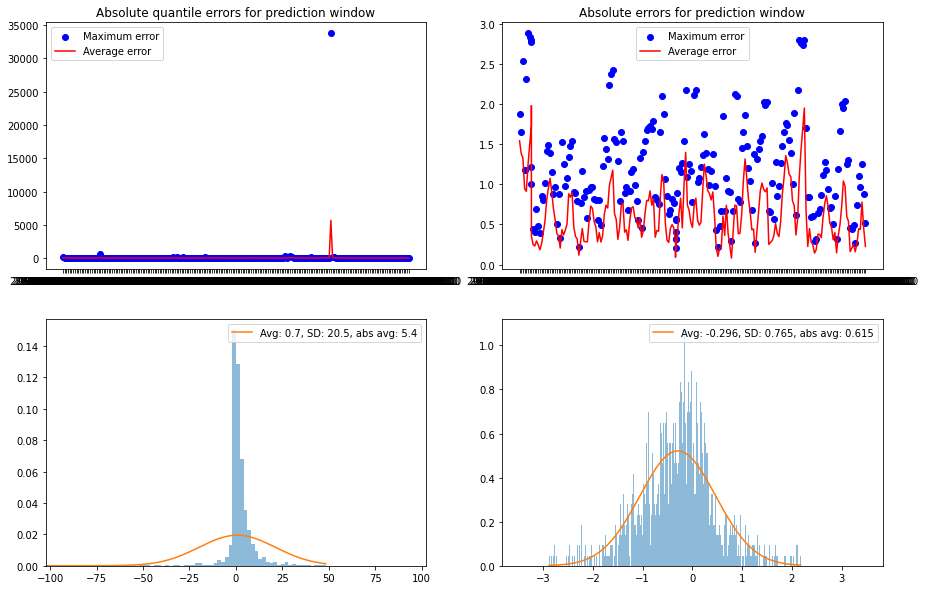

In [79]:
graph_errors(results[15])

In [87]:
test_df.describe()

y  day_of_week_sin  day_of_week_cos     month_sin  month_cos  \
count  220.000000     2.200000e+02       220.000000  2.200000e+02      220.0   
mean     7.605387    -1.889510e-01         0.090909 -2.449294e-16        1.0   
std      3.701694     6.762286e-01         0.709305  0.000000e+00        0.0   
min      1.245709    -8.660254e-01        -1.000000 -2.449294e-16        1.0   
25%      4.830123    -8.660254e-01        -0.500000 -2.449294e-16        1.0   
50%      6.540319    -2.449294e-16         0.500000 -2.449294e-16        1.0   
75%     10.792997     1.224647e-16         0.500000 -2.449294e-16        1.0   
max     18.545889     8.660254e-01         1.000000 -2.449294e-16        1.0   

         hour_sin      hour_cos           7           8           9  ...  \
count  220.000000  2.200000e+02  220.000000  220.000000  220.000000  ...   
mean    -0.010600  1.381390e-02    1.484545    0.040909   90.218182  ...   
std      0.707243  7.099779e-01    2.301466    1.894226    7.042444  ...   
min     -1.000000 -1.000000e+00   -6.600000   -6.700000   58.000000  ...   
25%     -0.707107 -7.071068e-01    0.675000   -0.800000   86.000000  ...   
50%      0.000000  6.123234e-17    1.800000    0.450000   92.000000  ...   
75%      0.707107  7.071068e-01    3.100000    1.200000   96.000000  ...   
max      1.000000  1.000000e+00    5.400000    4.800000  100.000000  ...   

               15          16            17            18           19  \
count  220.000000  220.000000    220.000000    220.000000   220.000000   
mean    37.127273   10.404545   1781.904545   2509.818182  1321.095455   
std    112.016560   19.135302   3633.699282   7733.632253  2462.160872   
min      0.000000    0.000000      0.000000      0.000000     0.000000   
25%      0.000000    0.000000      0.000000      0.000000     0.000000   
50%      0.000000    0.000000      0.000000      0.000000     0.000000   
75%      0.000000    9.000000   1026.250000      0.000000  1026.250000   
max    521.000000   66.000000  15173.000000  38784.000000  8465.000000   

                20          21          22          23          24  
count   220.000000  220.000000  220.000000  220.000000  220.000000  
mean    249.740909  140.363636    2.174091    6.636364    3.172727  
std     435.771453  113.623807    2.121646    3.079546    1.309321  
min       0.000000    0.000000    0.000000    0.000000    0.000000  
25%       0.000000   47.500000    1.000000    4.000000    2.000000  
50%       0.000000  115.000000    1.000000    8.000000    4.000000  
75%     310.750000  250.000000    3.600000    9.000000    4.000000  
max    1382.000000  340.000000    7.200000   10.000000    5.000000  

[8 rows x 25 columns]

In [86]:
forecast.at[place, "y"][0]

0.44473223542394474

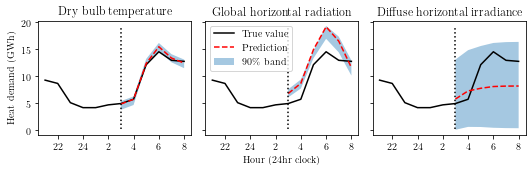

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7.5,2.5), sharey=True, sharex=True)

def rn(x):
    std = 3.223341298671542
    mean = 2.754259154070094
    y = np.asarray(x)
    return(y*std + mean)

forecast = results[7]
place = 103
back = 6

ax1.plot(test_df["ds"][place-back:place+6], test_df["y"][place-back:place+6], c="k", label="True value")
ax1.plot(test_df["ds"][place:place+6], rn(forecast.at[place,'median']), label="Prediction", c="r", ls="dashed")
#plt.plot(test_df["ds"][place:place+6], forecast.at[place,'y'], label="Actual")
ax1.axvline(x=test_df.iloc[place]["ds"], ymin=0.05, ymax=0.95, c="k", ls=":")
ax1.fill_between(x=test_df["ds"][place:place+6],y1=rn(forecast.at[place,'lo']), y2=rn(forecast.at[place,'hi']),alpha=0.4, label="90% confidence")
locs = ax1.get_xticks()
labels = ax1.get_xticklabels()
ax1.set_xticks(locs, test_df["ds"][place-back:place+6:2].dt.hour+1)
ax1.set_ylabel("Heat demand (GWh)")
ax1.set_title("Dry bulb temperature")

forecast = results[14]
place = 103

ax2.plot(test_df["ds"][place-back:place+6], test_df["y"][place-back:place+6], c="k", label="True value")
ax2.plot(test_df["ds"][place:place+6], rn(forecast.at[place,'median']), label="Prediction", c="r", ls="dashed")
#plt.plot(test_df["ds"][place:place+6], forecast.at[place,'y'], label="Actual")
ax2.axvline(x=test_df.iloc[place]["ds"], ymin=0.05, ymax=0.95, c="k", ls=":")
ax2.fill_between(x=test_df["ds"][place:place+6],y1=rn(forecast.at[place,'lo']), y2=rn(forecast.at[place,'hi']),alpha=0.4, label="90\% band")
#ax2.set_xticks([])
ax2.set_xlabel("Hour (24hr clock)")
ax2.set_title("Global horizontal radiation")
ax2.legend()

forecast = results[19]
place = 103

ax3.plot(test_df["ds"][place-back:place+6], test_df["y"][place-back:place+6], c="k")
ax3.plot(test_df["ds"][place:place+6], rn(forecast.at[place,'median']), label="Prediction", c="r", ls="dashed")
#plt.plot(test_df["ds"][place:place+6], forecast.at[place,'y'], label="Actual")
ax3.axvline(x=test_df.iloc[place]["ds"], ymin=0.05, ymax=0.95, c="k", ls=":")
ax3.fill_between(x=test_df["ds"][place:place+6],y1=rn(forecast.at[place,'lo']), y2=rn(forecast.at[place,'hi']),alpha=0.4, label="90% confidence")
#ax3.set_xticks([])
ax3.set_title("Diffuse horizontal irradiance")

#fig.suptitle("6hr Predictions", fontsize=15)

plt.tight_layout()
plt.savefig("goodbad.png", dpi=200)
plt.show()

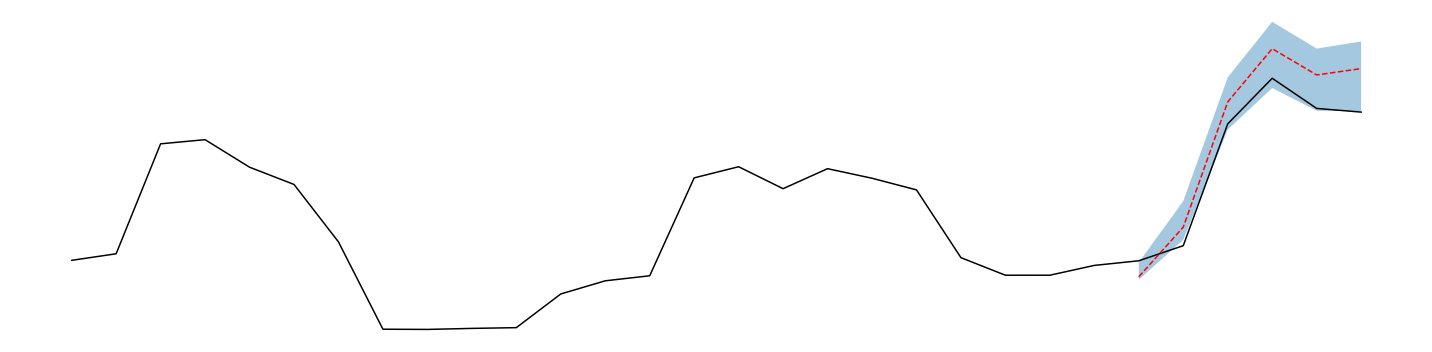

In [17]:
forecast = results[13]
place = 103
back = 24

plt.figure(figsize=(20,5))

plt.plot(test_df["ds"][place-back:place+6], test_df["y"][place-back:place+6], c="k", label="True value")
plt.plot(test_df["ds"][place:place+6], rn(forecast.at[place,'median']), label="Prediction", c="r", ls="dashed")
#plt.plot(test_df["ds"][place:place+6], forecast.at[place,'y'], label="Actual")
#plt.axvline(x=test_df.iloc[place]["ds"], ymin=0.05, ymax=0.95, c="k", ls=":")
plt.fill_between(x=test_df["ds"][place:place+6],y1=rn(forecast.at[place,'lo']), y2=rn(forecast.at[place,'hi']),alpha=0.4, label="90% confidence")
plt.xticks([])
plt.yticks([])

ax = plt.gca()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.savefig("title.png", dpi=200)
plt.show()

In [84]:
forecast

Unnamed: 0      max_q      avg_q   max_err   avg_err  \
0             0  88.257824  40.328785  1.880051  1.542799   
1             1  63.534199  24.381237  1.650816  1.383338   
2             2  44.142211  13.706688  2.541879  1.327656   
3             3  27.362909   5.815617  1.179880  0.945209   
4             4   2.808087   1.392804  2.310555  0.913298   
..          ...        ...        ...       ...       ...   
208         208   1.724928   0.990022  1.109281  0.446183   
209         209   1.453984   0.773095  0.968868  0.439198   
210         210   1.521218   1.009443  1.257426  0.779258   
211         211   1.325190   0.801852  0.873905  0.449381   
212         212   1.812405   0.671182  0.512834  0.225429   

                                                 all_q  \
0    [-46.5067738084281, -42.073673998320665, -88.2...   
1    [-63.53419850152581, -49.26677096905682, -26.9...   
2    [-44.14221094630332, 30.90061978812678, 2.0570...   
3    [27.362909241095966, 1.813427167003378, 1.9534...   
4    [1.485314510550102, 1.4858050425257607, 1.0230...   
..                                                 ...   
208  [-1.7249279896642977, -1.3608979698783308, -0....   
209  [-1.4539839442113056, 0.40713664280210426, -0....   
210  [-0.34325429043802774, -1.0700292346487221, -1...   
211  [-0.983334794604986, -1.3251904930992984, -0.2...   
212  [-1.8124053645217788, 0.33124666686365317, -0....   

                                               all_err                   ds  \
0    [-1.748689839971873, -1.541335672905913, -1.88...  2050-12-22 19:00:00   
1    [-1.620315165093413, -1.6508164148682831, -1.1...  2050-12-22 20:00:00   
2    [-2.541879270588803, -1.2065268580000146, -1.0...  2050-12-22 21:00:00   
3    [-1.179879588274215, -0.9202328835059397, -1.0...  2050-12-22 22:00:00   
4    [-0.7887924228240244, -0.7807065491424459, -0....  2050-12-22 23:00:00   
..                                                 ...                  ...   
208  [0.2715381288966356, 0.35625355027832445, 0.05...  2050-12-31 11:00:00   
209  [0.2681692697874492, -0.10901708288482026, 0.3...  2050-12-31 12:00:00   
210  [0.08262740688034698, 0.5063074361871094, 1.25...  2050-12-31 13:00:00   
211  [0.23207469101651612, 0.6916187326600014, 0.21...  2050-12-31 14:00:00   
212  [0.5128340046097695, -0.11693897297819733, 0.0...  2050-12-31 15:00:00   

                                                     y  \
0    [2.817560384405467, 2.680479139855376, 2.50258...   
1    [2.680479139855376, 2.5025800209397553, 1.0427...   
2    [2.5025800209397553, 1.0427644673864587, 1.045...   
3    [1.0427644673864587, 1.0456156645346872, 1.177...   
4    [1.0456156645346872, 1.1770877187000173, 0.960...   
..                                                 ...   
208  [0.40419943089874405, 0.3628387591966206, 1.10...   
209  [0.3628387591966206, 1.101229318812402, 1.1720...   
210  [1.101229318812402, 1.1720811593939453, 1.3515...   
211  [1.1720811593939453, 1.3515660245726646, 2.655...   
212  [1.3515660245726646, 2.6559452061935294, 2.730...   

                                                median  \
0    [1.0688705444335938, 1.139143466949463, 0.6225...   
1    [1.060163974761963, 0.8517636060714722, -0.130...   
2    [-0.03929924964904785, -0.1637623906135559, -0...   
3    [-0.13711512088775635, 0.12538278102874756, 0....   
4    [0.25682324171066284, 0.3963811695575714, 0.39...   
..                                                 ...   
208  [0.6757375597953796, 0.7190923094749451, 1.158...   
209  [0.6310080289840698, 0.9922122359275818, 1.506...   
210  [1.183856725692749, 1.6783885955810547, 2.6089...   
211  [1.4041558504104614, 2.043184757232666, 2.8733...   
212  [1.864400029182434, 2.539006233215332, 2.75352...   

                                                    hi  \
0    [1.0312697887420654, 1.1025092601776123, 0.601...   
1    [1.0346609354019165, 0.8182559013366699, -0.17...   
2    [-0.09688311815261841, -0.12471699714660645, 0...   


In [13]:
#labels = ["{}".format(n) for n in results]
labels = ["Control", "Dry bulb temp", "Dew point temp", "Humidity", "Atmos. pressure",
         "Extra. horiz. radiation", "Extra. direct normal radiation", "Horiz. IR radiation intensity",
         "Global horiz. radiation", "Direct normal radiation", "Diffuse horiz. radiation",
         "Global horiz. illuminance", "Direct normal illuminance", "Diffuse horiz. illuminance",
         "Zenith luminance", "Wind direction", "Wind speed", "Total sky cover", "Opaque sky cover"]
quants = [mus, sigmas, abs_avgs, mu2s, sigma2s, abs_avg2s, q_fracs]
quant_names = ["mus", "sigmas", "abs_avgs", "mu2s", "sigma2s", "abs_avg2s", "q_fracs"]
final_val = [0.06958, 0.06364, 0.06056, 0.08744, 0.09606, 0.1254, 0.05945, 0.09229, 0.1036, 0.1317, 0.1012, 0.08268, 0.1799, 0.2395, 0.2778, 0.1111, 0.1476, 0.1027, 0.07602]
final_train = [0.07331, 0.02342, 0.03891, 0.05995, 0.07657, 0.05676, 0.04572, 0.0399, 0.01762, 0.03009, 0.09099, 0.1126, 0.06099, 0.2655, 0.06173, 0.03502, 0.01395, 0.081, 0.05792]
#fig, ax = plt.subplots(3,3, figsize=(25,30))
#
#for m in range(7):
#    labels_temp = labels.copy()
#    c = ["b"]*len(labels)
#    for k in range(len(quants[m])):
#        if abs(quants[m][k])<abs(quants[m][0]):
#            c[k] = "r"
#        labels_temp[k] += " - " + str(round(quants[m][k],5))
#    ax[int((m-(m%3))/3),m%3].bar(labels_temp, quants[m], label=quant_names[m], color=c)
#
#for a in ax.flatten():
#    a.tick_params(rotation=90)
#    a.legend()
#fig.tight_layout(pad=5.0)
#    
#plt.show()

In [14]:
curves = pd.read_csv("curves.csv")
curves1 = curves.loc[curves["Step"] % 10 == 0]

In [20]:
#curves.head()
curves1.head()

Step  ancient-dream-13 - train_loss  ancient-dream-13 - train_loss__MIN  \
0      0                       0.654749                            0.654749   
10    10                       0.343951                            0.343951   
20    20                       0.326138                            0.326138   
30    30                       0.293472                            0.293472   
40    40                       0.290697                            0.290697   

    ancient-dream-13 - train_loss__MAX  ancient-dream-13 - valid_loss  \
0                             0.654749                       0.650603   
10                            0.343951                       0.296100   
20                            0.326138                       0.306473   
30                            0.293472                       0.259373   
40                            0.290697                       0.252794   

    ancient-dream-13 - valid_loss__MIN  ancient-dream-13 - valid_loss__MAX  \
0                             0.650603                            0.650603   
10                            0.296100                            0.296100   
20                            0.306473                            0.306473   
30                            0.259373                            0.259373   
40                            0.252794                            0.252794   

    quiet-pyramid-11 - train_loss  quiet-pyramid-11 - train_loss__MIN  \
0                        0.695854                            0.695854   
10                       0.326286                            0.326286   
20                       0.284501                            0.284501   
30                       0.248536                            0.248536   
40                       0.254080                            0.254080   

    quiet-pyramid-11 - train_loss__MAX  quiet-pyramid-11 - valid_loss  \
0                             0.695854                       0.512769   
10                            0.326286                       0.280705   
20                            0.284501                       0.224604   
30                            0.248536                       0.229788   
40                            0.254080                       0.213499   

    quiet-pyramid-11 - valid_loss__MIN  quiet-pyramid-11 - valid_loss__MAX  
0                             0.512769                            0.512769  
10                            0.280705                            0.280705  
20                            0.224604                            0.224604  
30                            0.229788                            0.229788  
40                            0.213499                            0.213499

In [15]:
fake = np.asarray([i for i in range(20,160,10)])
jitter = [random.randrange(-100,100)/1000 for i in fake]
fakey = (fake)**2/50000 + jitter + 0.3

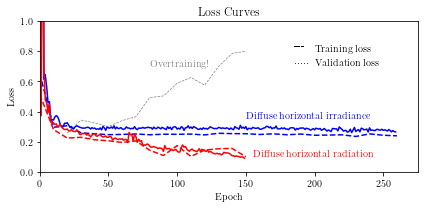

In [16]:
plt.figure(figsize=(6,3))

plt.plot(curves["Step"], curves["ancient-dream-13 - train_loss"], c="blue")
plt.plot(curves1["Step"], curves1["ancient-dream-13 - valid_loss"], c="blue", ls="dashed")

plt.plot(curves["Step"], curves["quiet-pyramid-11 - train_loss"], c="red")
plt.plot(curves1["Step"], curves1["quiet-pyramid-11 - valid_loss"], c="red", ls="dashed")

plt.plot(fake, fakey, c="gray", ls="dashed", lw=0.7)

plt.xlim([0,275])
plt.ylim([0,1])
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.text(185, 0.83, "___")
plt.text(185, 0.72, ".....")
plt.text(200, 0.8, "Training loss")
plt.text(200, 0.7, "Validation loss")

plt.text(155, 0.1, "Diffuse horizontal radiation", c="r")
plt.text(150, 0.35, "Diffuse horizontal irradiance", c="b")
plt.text(80, 0.7, "Overtraining!", c="gray")

plt.tight_layout()
plt.savefig("curves.png", dpi=200)
plt.show()

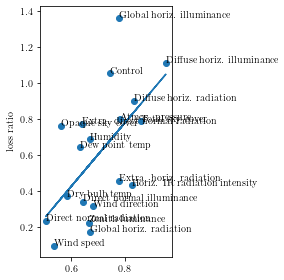

In [17]:
final_train = np.asarray(final_train)
final_val = np.asarray(final_val)

x = np.asarray(q_fracs)
y = final_train/final_val

plt.figure(figsize=(4,4))

a, b = np.polyfit(x, y, 1)

plt.plot(x, a*x +b)

#plt.xticks([])
#plt.yticks([])

plt.xlabel("% within bands")
plt.ylabel("loss ratio")

#plt.xlim([0.4,1])
#plt.ylim([0,0.25])
plt.scatter(x, y)
for i in range(len(x)):
    plt.text(x[i], y[i], labels[i])
plt.tight_layout()
plt.savefig("ratio.png", dpi=200)
plt.show()

                             names    errors   errors2   errors3
14                Zenith luminance  2.865920  0.667449  1.132034
13      Diffuse horiz. illuminance  2.833381  0.954617  1.042728
4                  Atmos. pressure  2.679651  0.781690  1.027001
6   Extra. direct normal radiation  2.224850  0.640845  0.971722
12       Direct normal illuminance  2.071669  0.643192  0.936026
15                  Wind direction  1.992345  0.682316  0.852018
9          Direct normal radiation  1.980865  0.503912  0.820663
8          Global horiz. radiation  1.860373  0.669797  0.805012
0                          Control  1.919294  0.746479  0.795996
7    Horiz. IR radiation intensity  1.625239  0.827074  0.793947
17                 Total sky cover  1.898196  0.859937  0.779910
5          Extra. horiz. radiation  1.840597  0.779343  0.773435
16                      Wind speed  1.795140  0.533646  0.748688
2                   Dew point temp  1.818603  0.632238  0.719674
3                        

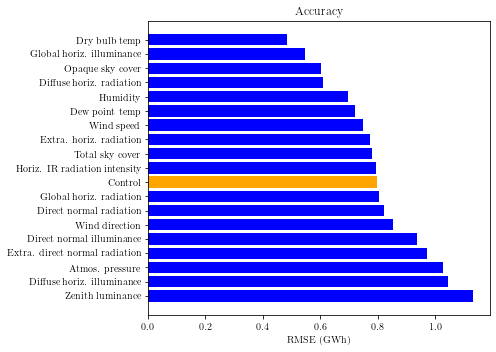

In [18]:
error_df = pd.DataFrame()
error_df["names"] = labels
error_df["errors"] = (np.asarray(abs_avg2s) * 3.223341298671542)
error_df["errors2"] = np.asarray(q_fracs)
error_df["errors3"] = np.sqrt(rmses)

error_df = error_df.sort_values(by=["errors3"], ascending=False)

plt.figure(figsize=(7,5))
plt.title("Accuracy")
plt.xlabel("RMSE (GWh)")

plt.barh(error_df["names"], error_df["errors3"], color=["b"]*8 + ["orange"] + ["b"]*10)
plt.tight_layout()
plt.savefig("errors.png", dpi=200)
plt.plot()

print(error_df)

[]

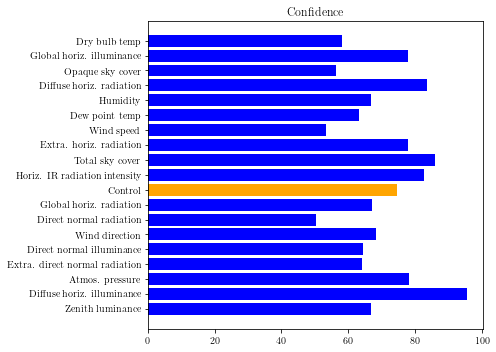

In [19]:
plt.figure(figsize=(7,5))
plt.title("Confidence")
plt.xlabel("% true values within confidence band")

plt.barh(error_df["names"], error_df["errors2"]*100, color=["b"]*8 + ["orange"] + ["b"]*10)
plt.tight_layout()
plt.savefig("errors2.png", dpi=200)
plt.plot()

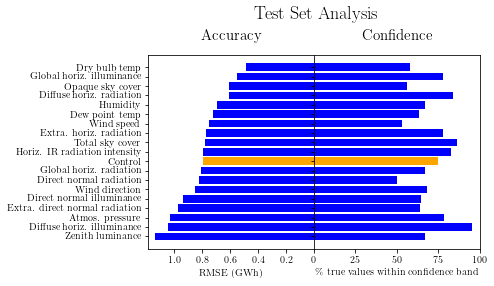

In [40]:
fig, axes = plt.subplots(figsize=(6,3), ncols=2, sharey=True)
fig.tight_layout()

axes[0].barh(error_df["names"], error_df["errors3"], color=["b"]*8 + ["orange"] + ["b"]*10, align="center")
axes[0].set_title("Accuracy", fontsize=15, pad=15)
axes[0].set_xlabel("RMSE (GWh)")
axes[0].set_xticks([0.2, 0.4, 0.6, 0.8, 1.0])
axes[1].barh(error_df["names"], error_df["errors2"]*100, color=["b"]*8 + ["orange"] + ["b"]*10, align="center")
axes[1].set_title("Confidence", fontsize=15, pad=15)
axes[1].set_xlabel("\% true values within confidence band")

axes[0].invert_xaxis() 

fig.suptitle("Test Set Analysis", fontsize=18, x=0.57, y=1.22)

plt.subplots_adjust(wspace=0, top=1, bottom=0.1, left=0.18, right=0.95)

plt.savefig("test_analysis.png", dpi=200, bbox_inches="tight")
plt.show()

plt.show()